In [1]:
# %load_ext tensorboard
%reload_ext tensorboard

# Part 1

## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, decomposition, metrics, model_selection, preprocessing

## Initializing Functions

In [3]:
def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    # y = y.reshape(-1, 1)

    return X, y

In [4]:
def plot_decision_boundary_2D(pred_func, X, y, binary_class=True):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])

    if binary_class:
      Z = Z.reshape(xx.shape)
      plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
      plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), cmap=plt.cm.Spectral)

    else:
      Z = np.argmax(Z, axis=1).reshape(xx.shape)
      plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
      plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), cmap=plt.cm.Spectral)

    plt.title("2D Decision Boundary")
    plt.show()

In [5]:
def plot_decision_boundary_3D(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    z_min, z_max = X[:, 2].min() - .5, X[:, 2].max() + .5

    h = 0.01

    xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h),
                             np.arange(z_min, z_max, h))

    Z = pred_func(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])

    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    for i in range(Z.shape[2]):
        z = zz[:, :, i]
        z_value = z[0, 0]
        ax.contourf(xx[:, :, i], yy[:, :, i], z, Z[:, :, i], levels=[-0.5, -0.25, 0.0, 0.25, 0.5], alpha=0.7)

    for i, color in zip(range(3), ['r', 'g', 'b']):
        idx = np.where(np.argmax(y, axis=1) == i)
        ax.scatter(X[idx, 0], X[idx, 1], X[idx, 2], c=color, label=f'Class {i}', alpha=0.3, edgecolors='k')

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.title("3D Decision Boundary")
    plt.show()

In [6]:
def plot_decision_boundary_3D_no_hyperp(pred_func, X, y):
    '''
    plot the decision boundary
    :param pred_func: function used to predict the label
    :param X: input data
    :param y: given labels
    :return:
    '''
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    z_min, z_max = X[:, 2].min() - .5, X[:, 2].max() + .5

    h = 0.01

    xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h),
                             np.arange(z_min, z_max, h))

    Z = pred_func(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])

    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    for i, color in zip(range(3), ['r', 'g', 'b']):
        idx = np.where(np.argmax(y, axis=1) == i)
        ax.scatter(X[idx, 0], X[idx, 1], X[idx, 2], c=color, label=f'Class {i}', alpha=0.6, edgecolors='k')

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.title("3D Decision Boundary")
    plt.show()

## Initializing NeuralNetwork object

In [7]:
class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        :param nn_input_dim: input dimension
        :param nn_hidden_dim: the number of hidden units
        :param nn_output_dim: output dimension
        :param actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        :param reg_lambda: regularization coefficient
        :param seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda

        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z, af_type):
        '''
        actFun computes the activation functions
        :param z: net input
        :param af_type: Tanh, Sigmoid, or ReLU
        :return: activations
        '''
        if af_type == 'Tanh':
            return np.tanh(z)
        elif af_type == 'ReLU':
            return np.maximum(0, z)
        elif af_type == 'Sigmoid':
            return 1 / (1 + np.exp(-z))
        else:
            raise ValueError("Invalid activation function type")


    def diff_actFun(self, z, af_type):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        :param z: net input
        :param af_type: Tanh, Sigmoid, or ReLU
        :return: the derivatives of the activation functions wrt the net input
        '''
        if af_type == 'Sigmoid':
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif af_type == 'Tanh':
            return 1 - np.tanh(z)**2
        elif af_type == 'ReLU':
            return (z > 0).astype(float)
        else:
            raise ValueError("Invalid activation function type")


    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1
        :param X: input data
        :param actFun: activation function
        :return:
        '''
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = actFun(z=self.z1, af_type=self.actFun_type)
        self.z2 = self.a1.dot(self.W2) + self.b2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        :param X: input data
        :param y: given labels
        :return: the loss for prediction
        '''
        self.feedforward(X, lambda z, af_type: self.actFun(z=z, af_type=af_type))

        # Calculating the loss
        corect_logprobs = -np.log(self.probs[range(len(X)), y])
        data_loss = np.sum(corect_logprobs)

        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return (1. / len(X)) * data_loss

    def predict(self, X):
        '''
        predict infers the label of a given data point X
        :param X: input data
        :return: label inferred
        '''
        self.feedforward(X, lambda z, af_type: self.actFun(z=z, af_type=af_type))
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
        '''
        backprop implements backpropagation to compute the gradients used to update the parameters in the backward step
        :param X: input data
        :param y: given labels
        :return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''
        delta3 = self.probs
        delta3[range(len(X)), y] -= 1
        dW2 = (self.a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(self.W2.T) * self.diff_actFun(z=self.z1, af_type=self.actFun_type)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        return dW1, dW2, db1, db2

    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
        '''
        fit_model uses backpropagation to train the network
        :param X: input data
        :param y: given labels
        :param num_passes: the number of times that the algorithm runs through the whole dataset
        :param print_loss: print the loss or not
        :return:
        '''
        # Gradient descent.
        for i in range(0, num_passes):
            # Forward propagation
            self.feedforward(X, lambda z, af_type: self.actFun(z=z, af_type=af_type))
            # Backpropagation
            dW1, dW2, db1, db2 = self.backprop(X, y)

            # Add regularization terms (b1 and b2 don't have regularization terms)
            dW2 += self.reg_lambda * self.W2
            dW1 += self.reg_lambda * self.W1

            # Gradient descent parameter update
            self.W1 += -epsilon * dW1
            self.b1 += -epsilon * db1
            self.W2 += -epsilon * dW2
            self.b2 += -epsilon * db2

            # Optionally print the loss.
            # This is expensive because it uses the whole dataset, so we don't want to do it too often.
            if print_loss and i % 1000 == 0:
                print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
        '''
        visualize_decision_boundary plots the decision boundary created by the trained network
        :param X: input data
        :param y: given labels
        :return:
        '''
        plot_decision_boundary_2D(lambda x: self.predict(x), X, y)

## Plot original "Make Moons" dataset

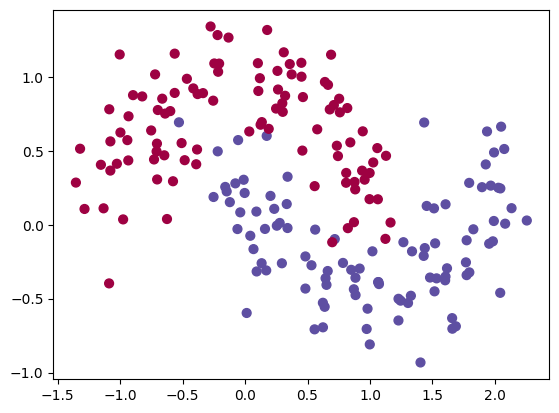

In [8]:
X, y = generate_data()

plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

## Fit 3-hidden-layer neural network with "TanH" as its activation function

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068950
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


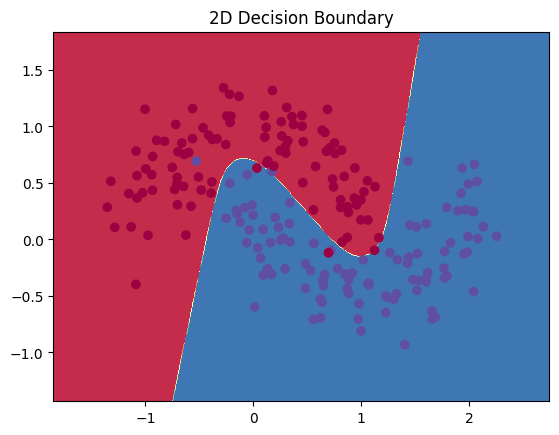

In [9]:
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='Tanh')
model.fit_model(X, y)
model.visualize_decision_boundary(X, y)

## Fit 3-hidden-layer neural network with "Sigmoid" as its activation function

Loss after iteration 0: 0.628571
Loss after iteration 1000: 0.088431
Loss after iteration 2000: 0.079598
Loss after iteration 3000: 0.078604
Loss after iteration 4000: 0.078330
Loss after iteration 5000: 0.078233
Loss after iteration 6000: 0.078192
Loss after iteration 7000: 0.078174
Loss after iteration 8000: 0.078166
Loss after iteration 9000: 0.078161
Loss after iteration 10000: 0.078159
Loss after iteration 11000: 0.078158
Loss after iteration 12000: 0.078157
Loss after iteration 13000: 0.078156
Loss after iteration 14000: 0.078156
Loss after iteration 15000: 0.078156
Loss after iteration 16000: 0.078156
Loss after iteration 17000: 0.078156
Loss after iteration 18000: 0.078156
Loss after iteration 19000: 0.078155


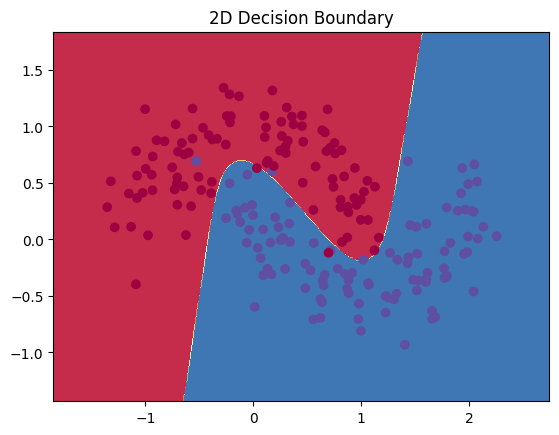

In [10]:
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='Sigmoid')
model.fit_model(X, y)
model.visualize_decision_boundary(X, y)

## Fit 3-hidden-layer neural network with "ReLU" as its activation function

Loss after iteration 0: 0.560274
Loss after iteration 1000: 0.072179
Loss after iteration 2000: 0.071301
Loss after iteration 3000: 0.071159
Loss after iteration 4000: 0.071190
Loss after iteration 5000: 0.071136
Loss after iteration 6000: 0.071276
Loss after iteration 7000: 0.071090
Loss after iteration 8000: 0.071265
Loss after iteration 9000: 0.071084
Loss after iteration 10000: 0.071090
Loss after iteration 11000: 0.071087
Loss after iteration 12000: 0.071086
Loss after iteration 13000: 0.071069
Loss after iteration 14000: 0.071114
Loss after iteration 15000: 0.071074
Loss after iteration 16000: 0.071113
Loss after iteration 17000: 0.071071
Loss after iteration 18000: 0.071090
Loss after iteration 19000: 0.071219


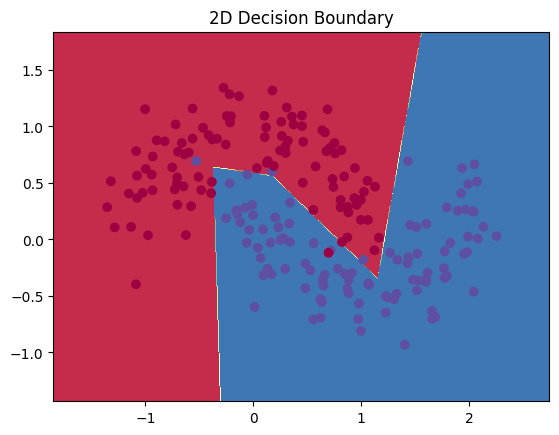

In [11]:
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3 , nn_output_dim=2, actFun_type='ReLU')
model.fit_model(X, y)
model.visualize_decision_boundary(X, y)

## Testing several n-hidden-layer neural networks with "TanH" as its activation function


3 hidden dims:


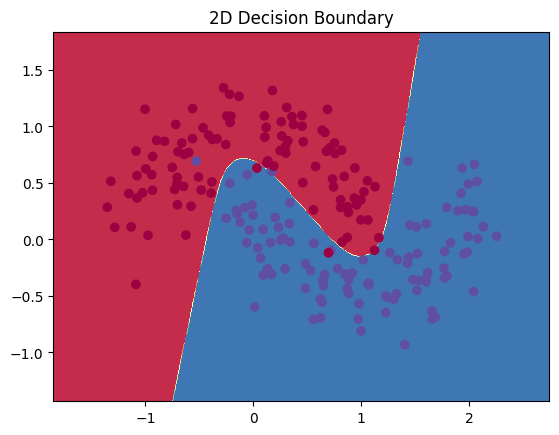


5 hidden dims:


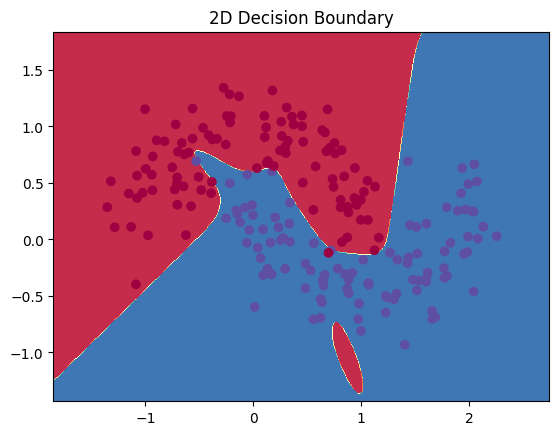


10 hidden dims:


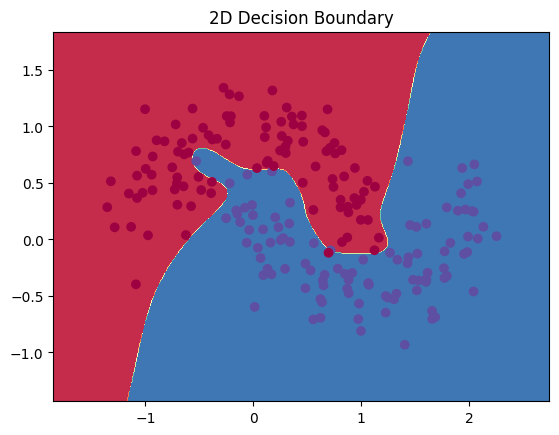


20 hidden dims:


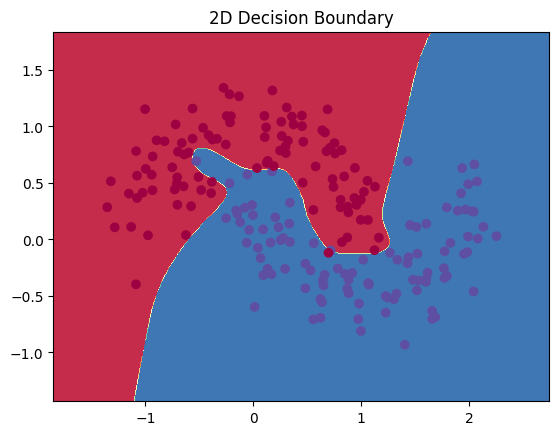


30 hidden dims:


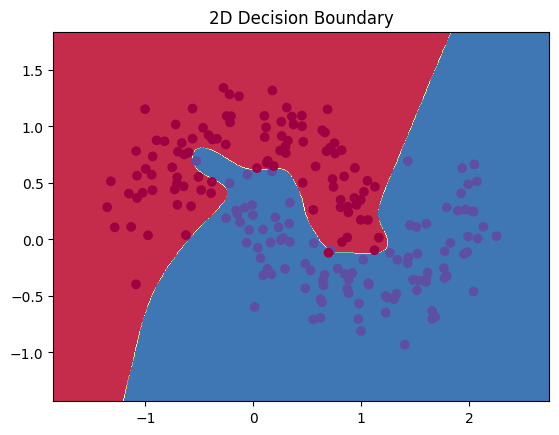

In [12]:
for hidden_dim in [3, 5, 10, 20, 30]:
    model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=hidden_dim, nn_output_dim=2, actFun_type='Tanh')
    print(f"\n{hidden_dim} hidden dims:")
    model.fit_model(X, y, print_loss=False)
    plot_decision_boundary_2D(lambda x: model.predict(x), X, y)

## Configurable Neural Network experiment ($n$ number of layers and $m_{n_{i}}$ layer sizes)

### Initializing Generic Layer Object

In [13]:
class Layer:
    def __init__(self, input_size, output_size, activation='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        # Initialize weights with small random values
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))

    def activate(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'softmax':
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        else:
            return x  # linear activation

    def feedforward(self, a_prev):
        self.a_prev = a_prev
        self.z = np.dot(a_prev, self.W) + self.b
        self.a = self.activate(self.z)
        return self.a

    def backprop(self, delta_next, W_next, learning_rate):
        if self.activation == 'relu':
            delta = np.dot(delta_next, W_next.T) * (self.z > 0)
        elif self.activation == 'sigmoid':
            delta = np.dot(delta_next, W_next.T) * (self.a * (1 - self.a))
        else:  # linear or softmax, delta will be directly passed
            delta = delta_next

        dW = np.dot(self.a_prev.T, delta)
        db = np.sum(delta, axis=0, keepdims=True)
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return delta

### Initializing the modular Deep Neural Network

In [14]:
class DeepNeuralNetwork:
    def __init__(self, layer_sizes, activation_functions):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            layer = Layer(layer_sizes[i], layer_sizes[i + 1], activation=activation_functions[i])
            self.layers.append(layer)

    def feedforward(self, X):
        a = X
        for layer in self.layers:
            a = layer.feedforward(a)
        return a

    def backprop(self, y, output, learning_rate):
        m = y.shape[0]
        delta_output = output - y
        for i in reversed(range(len(self.layers))):
            if i == len(self.layers) - 1:
                delta = delta_output
            else:
                delta = self.layers[i].backprop(delta, self.layers[i + 1].W, learning_rate)

    def calculate_loss(self, X, y, reg_lambda):
        output = self.feedforward(X)
        loss = -np.sum(y * np.log(output))
        for layer in self.layers:
            loss += reg_lambda / 2 * np.sum(layer.W ** 2)
        return loss / X.shape[0]

    def fit_model(self, X, y, epochs=100000, learning_rate=0.01, reg_lambda=0.01, print_loss=True):
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backprop(y, output, learning_rate)
            if print_loss and epoch % 1000 == 0:
                loss = self.calculate_loss(X, y, reg_lambda)
                print(f"Loss after iteration {epoch}: {loss}")

    def predict(self, X):
        output = self.feedforward(X)
        return np.round(output)

### Regenerate "Make Moons" dataset for new DNN compatibility with labels

In [15]:
X, y = generate_data()

y = y.reshape(-1, 1)

### Initialize the deep neural network with 3 layers: [2, 4, 1]

In [16]:
layer_sizes = [2, 4, 1]

activation_functions = ['relu', 'sigmoid']

dnn = DeepNeuralNetwork(layer_sizes, activation_functions)

### Train the model and plot decision boundary

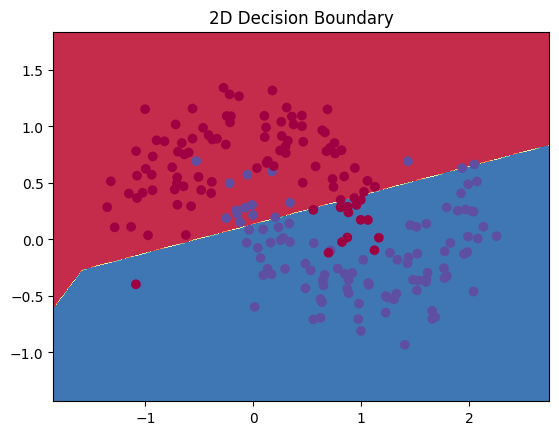

In [17]:
dnn.fit_model(X, y, epochs=100000, print_loss=False)

plot_decision_boundary_2D(lambda x: dnn.predict(x), X, y)

### Evaluate the model

In [18]:
y_pred = dnn.predict(X)

print(f"Accuracy: {metrics.accuracy_score(y, y_pred) * 100:.2f}%")

Accuracy: 84.50%


## Experiments with different configurations for binary classification

### Function to run experiments on Make_Moons dataset

In [19]:
def run_experiment(layer_sizes, activation_functions, epochs=100000, learning_rate=0.01, reg_lambda=0.01, plot_title=""):
    print(f"\nRunning experiment with layer_sizes = {layer_sizes}, activation_functions = {activation_functions}")
    dnn_exp = DeepNeuralNetwork(layer_sizes, activation_functions)
    dnn_exp.fit_model(X, y, epochs=epochs, learning_rate=learning_rate, reg_lambda=reg_lambda, print_loss=False)
    print(f"Accuracy: {metrics.accuracy_score(y, dnn_exp.predict(X)) * 100:.2f}%")
    plot_decision_boundary_2D(lambda x: dnn_exp.predict(x), X, y)

### Shallow vs Deep Networks


Running experiment with layer_sizes = [2, 4, 4, 4, 1], activation_functions = ['relu', 'relu', 'relu', 'sigmoid']
Accuracy: 50.00%


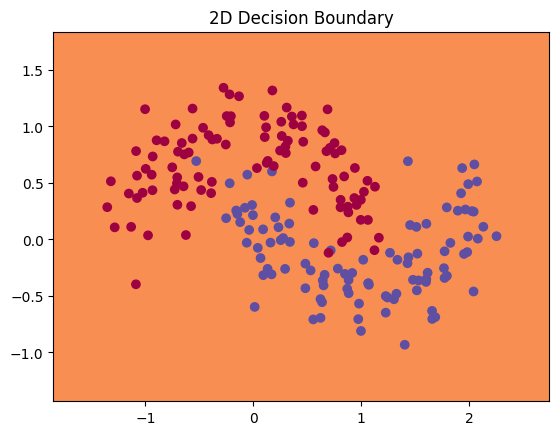


Running experiment with layer_sizes = [2, 4, 1], activation_functions = ['relu', 'sigmoid']
Accuracy: 82.00%


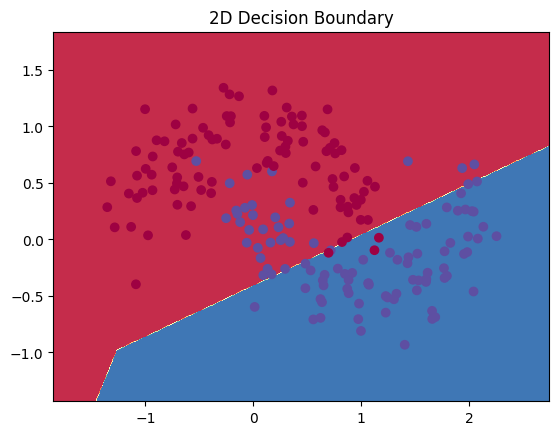

In [20]:
run_experiment([2, 4, 4, 4, 1], ['relu', 'relu', 'relu', 'sigmoid'], plot_title="Deep Network: [2, 4, 4, 4, 1]")
run_experiment([2, 4, 1], ['relu', 'sigmoid'], plot_title="Shallow Network: [2, 4, 1]")

### Different Activation Functions in hidden layers (other than relu)


Running experiment with layer_sizes = [2, 4, 1], activation_functions = ['sigmoid', 'sigmoid']
Accuracy: 84.50%


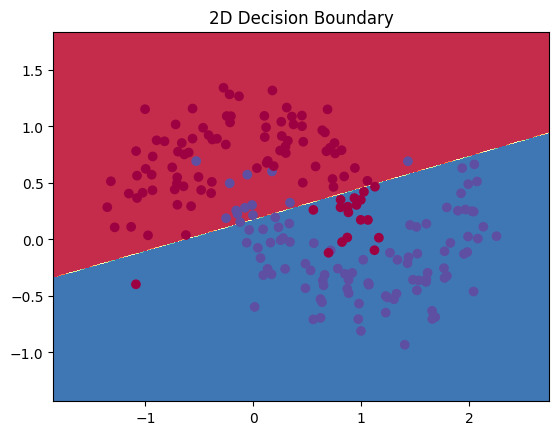

In [21]:
run_experiment([2, 4, 1], ['sigmoid', 'sigmoid'], plot_title="Shallow Network with Sigmoid: [2, 4, 1]")

### Different Layer Sizes in hidden layers


Running experiment with layer_sizes = [2, 8, 1], activation_functions = ['relu', 'sigmoid']
Accuracy: 85.00%


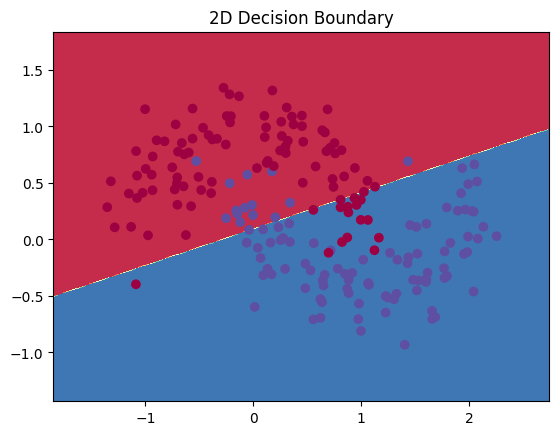

In [22]:
run_experiment([2, 8, 1], ['relu', 'sigmoid'], plot_title="Shallow Network with Larger Hidden Layer: [2, 8, 1]")

## Experiments on different dataset for multiclassification ("load_iris" w/ three distinct class labels)

### Load Iris dataset

In [23]:
X_iris = datasets.load_iris().data
y_iris = datasets.load_iris().target.reshape(-1, 1)

### One-hot encode the labels

In [24]:
# encoder = preprocessing.OneHotEncoder(sparse=False)
y_iris_onehot = preprocessing.OneHotEncoder(sparse=False).fit_transform(y_iris)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Split the "load_iris" data into training and test sets


In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_iris, y_iris_onehot, test_size=0.2, random_state=42)

### Initialize and train the deep neural network with 3 layers: [4, 5, 3]

In [26]:
layer_sizes_iris = [4, 5, 3]

activation_functions_iris = ['relu', 'softmax']

dnn_iris = DeepNeuralNetwork(layer_sizes_iris, activation_functions_iris)

dnn_iris.fit_model(X_train, y_train, epochs=100000, learning_rate=0.005, reg_lambda=0.01, print_loss=False)

### Evaluate the model on test data

In [27]:
# y_test_pred = dnn_iris.predict(X_test)
# y_test_class = np.argmax(y_test, axis=1)
# y_test_pred_class = np.argmax(y_test_pred, axis=1)
print(f"Accuracy on Iris dataset: {metrics.accuracy_score(np.argmax(y_test, axis=1), np.argmax(dnn_iris.predict(X_test), axis=1)) * 100:.2f}%")

Accuracy on Iris dataset: 63.33%


### Apply PCA to reduce dimensions to 2 and 3 features for plotting

#### Two-dimensional PCA

##### Initialize 2D PCA

In [28]:
pca_2d = decomposition.PCA(n_components=2)

X_train_2d = pca_2d.fit_transform(X_train)

X_test_2d = pca_2d.transform(X_test)

##### Initialize and train models on the reduced feature sets

In [29]:
dnn_2d = DeepNeuralNetwork([2, 5, 3], ['relu', 'softmax'])

dnn_2d.fit_model(X_train_2d, y_train, epochs=100000, learning_rate=0.01, reg_lambda=0.01)

Loss after iteration 0: 1.098385487369922
Loss after iteration 1000: 0.9082320421692393
Loss after iteration 2000: 0.8231367063929823
Loss after iteration 3000: 0.7795857381058384
Loss after iteration 4000: 0.7551306229952008
Loss after iteration 5000: 0.7408932257080784
Loss after iteration 6000: 0.7327473547236737
Loss after iteration 7000: 0.7285624492795755
Loss after iteration 8000: 0.7272470774868071
Loss after iteration 9000: 0.7280486205948803
Loss after iteration 10000: 0.7304193782206853
Loss after iteration 11000: 0.734009740187467
Loss after iteration 12000: 0.7385320796999898
Loss after iteration 13000: 0.7438091251492599
Loss after iteration 14000: 0.7498052404825255
Loss after iteration 15000: 0.7563492959637887
Loss after iteration 16000: 0.7633475390868166
Loss after iteration 17000: 0.7707086289712995
Loss after iteration 18000: 0.7783732157500224
Loss after iteration 19000: 0.7862022814997052
Loss after iteration 20000: 0.7942069448539932
Loss after iteration 21000: 

##### Plot the 2D decision boundary

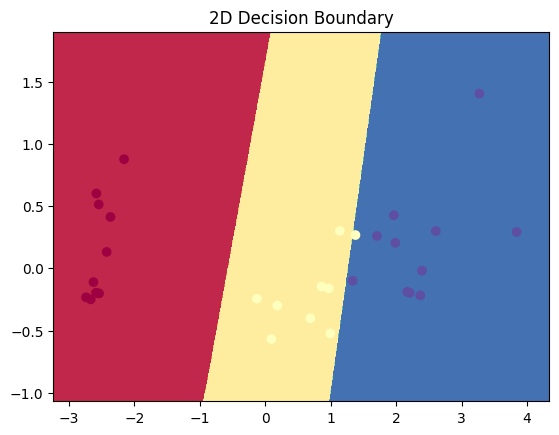

In [30]:
plot_decision_boundary_2D(lambda x: dnn_2d.feedforward(x), X_test_2d, y_test, binary_class=False)

#### Three-dimensional PCA

##### Initialize 3D PCA

In [31]:
pca_3d = decomposition.PCA(n_components=3)

X_train_3d = pca_3d.fit_transform(X_train)

X_test_3d = pca_3d.transform(X_test)

##### Initialize and train models on the reduced feature sets

In [32]:
dnn_3d = DeepNeuralNetwork([3, 5, 3], ['relu', 'softmax'])

dnn_3d.fit_model(X_train_3d, y_train, epochs=100000, learning_rate=0.01, reg_lambda=0.01)

Loss after iteration 0: 1.098308475136801
Loss after iteration 1000: 0.9906444252937125
Loss after iteration 2000: 0.954871982066615
Loss after iteration 3000: 0.9382897174596468
Loss after iteration 4000: 0.9295555776334246
Loss after iteration 5000: 0.9250086217352269
Loss after iteration 6000: 0.9233099561248992
Loss after iteration 7000: 0.9234668772213295
Loss after iteration 8000: 0.9251553347527113
Loss after iteration 9000: 0.9280403926440154
Loss after iteration 10000: 0.9318139862591991
Loss after iteration 11000: 0.9363266168132901
Loss after iteration 12000: 0.9414682388323565
Loss after iteration 13000: 0.9471550104335591
Loss after iteration 14000: 0.9533243677289496
Loss after iteration 15000: 0.9599471913864742
Loss after iteration 16000: 0.9669945494845744
Loss after iteration 17000: 0.9743826510281886
Loss after iteration 18000: 0.9820774328769377
Loss after iteration 19000: 0.9901496105127336
Loss after iteration 20000: 0.9985429398760287
Loss after iteration 21000: 

##### Plot the 3D decision boundaries

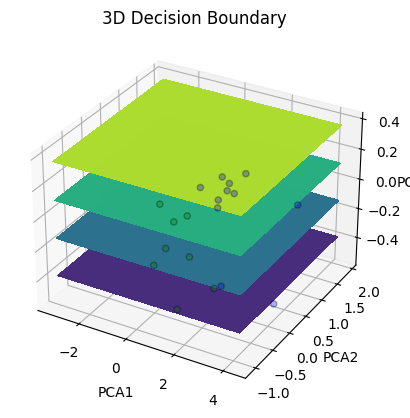

In [33]:
plot_decision_boundary_3D(lambda x: dnn_3d.feedforward(x), X_test_3d, y_test)

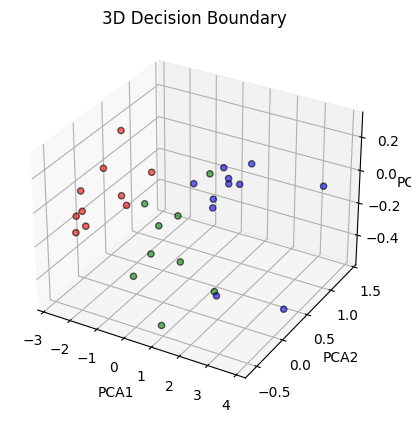

In [34]:
plot_decision_boundary_3D_no_hyperp(lambda x: dnn_3d.feedforward(x), X_test_3d, y_test)

# Part 2

## PyTorch Tutorial

In [35]:
import torch
import numpy as np

In [36]:
ndarray = np.array([0, 1, 2])
t = torch.from_numpy(ndarray)
print(t)

print(t.shape)
print(t.dtype)
print(t.device)

tensor([0, 1, 2])
torch.Size([3])
torch.int64
cpu


In [37]:
t = torch.tensor([0, 1, 2])
print(t)

tensor([0, 1, 2])


In [38]:
ndarray = np.array([[0, 1, 2], [3, 4, 5]])
t = torch.from_numpy(ndarray)
print(t)

tensor([[0, 1, 2],
        [3, 4, 5]])


In [39]:
new_t = torch.rand_like(t, dtype=torch.float)
print(new_t)

tensor([[0.9808, 0.2595, 0.0774],
        [0.0887, 0.7406, 0.3836]])


In [40]:
my_shape = (3, 3)
rand_t = torch.rand(my_shape)
print(rand_t)

tensor([[0.3803, 0.7897, 0.2752],
        [0.6571, 0.2989, 0.4621],
        [0.1073, 0.4017, 0.4276]])


In [41]:
zeros_tensor = torch.zeros((2, 3))
print(zeros_tensor)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [42]:
print(zeros_tensor[1])
print(zeros_tensor[:, 0])

tensor([0., 0., 0.])
tensor([0., 0.])


In [43]:
transposed = zeros_tensor.T
print(transposed)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])


In [44]:
ones_tensor = torch.ones(3, 3)
product = torch.matmul(zeros_tensor, ones_tensor)
print(product)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [45]:
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(root=".", train=True, download=True, transform=ToTensor())

test_data = datasets.MNIST(root=".", train=False, download=True, transform=ToTensor())

In [46]:
training_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

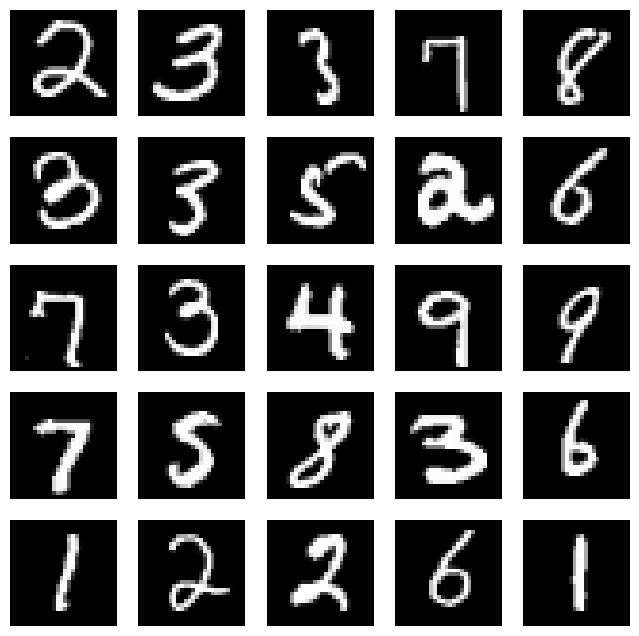

In [47]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [48]:
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [49]:
from torch.utils.data import DataLoader

loaded_train = DataLoader(training_data, batch_size=64, shuffle=True)
loaded_test = DataLoader(test_data, batch_size=64, shuffle=True)

In [50]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [51]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [52]:
loss_function = nn.CrossEntropyLoss()

In [53]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [54]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [55]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [56]:
torch.save(model, "model.pth")
model = torch.load("model.pth")

In [57]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(loaded_train, model, loss_function, optimizer)
    test(loaded_test, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 2.313453  [    0/60000]
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.304398 

Epoch 2
-------------------------------
loss: 2.294496  [    0/60000]
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.304418 

Epoch 3
-------------------------------
loss: 2.309762  [    0/60000]
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.304309 

Epoch 4
-------------------------------
loss: 2.309878  [    0/60000]
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.304389 

Epoch 5
-------------------------------
loss: 2.303256  [    0/60000]
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.304383 

Done!


## Writing Network Code

### MNIST Data Wrangling

#### Importing libraries

In [58]:
import os
from datetime import datetime
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

#### Initializing hyperparameters/variables

In [59]:
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.01
try_cuda = True
seed = 1000
logging_interval = 10
logging_dir = None

#### Setting up the logging

In [60]:
datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    base_folder = Path("./runs/")
    base_folder.mkdir(parents=True, exist_ok=True)
    logging_dir = base_folder / Path(datetime_str)
    logging_dir.mkdir(exist_ok=True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#### Deciding whether to send to the cpu or not if available

In [61]:
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.mnaual_seed(seed)

else:
    cuda = False
    torch.manual_seed(seed)

print(cuda)

False


#### Setting up the data loaders

In [62]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.01307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data',
        train=True,
        download=True,
        transform=transform,
        ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data',
        train=False,
        download=True,
        transform=transform,
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [63]:
len(train_loader), len(test_loader)

(938, 157)

### MNIST DCN

In [64]:
# Defining Architecture, loss, and optimizer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        print(self.conv1, "\n", self.conv2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        # super(Net, self).__init__()
        # self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)  # (batch_size, units)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        # x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # x = x.view(-1, 1024) # (batch_size, units)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = F.softmax(x,dim=1)

        return x

model = Net()
if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)


# Visualize network as a graph on TensorBoard
input_tensor = torch.Tensor(1,1,28,28)
if cuda:
    input_tensor = input_tensor.cuda()
writer.add_graph(model, input_to_model=input_tensor)

Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)) 
 Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))


### Training and Testing Functions

In [65]:
eps = 1e-13

#### defining the trainig loop

In [66]:
def train(epoch):
    model.train()
    criterion = nn.NLLLoss()
    #criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data) # forward
        loss = criterion(torch.log(output+eps), target) # = sum_k(-t_k * log(y_k))
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                    ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            # Log train/loss to TensorBoard at every iteration
            n_iter = (epoch - 1) * len(train_loader) + batch_idx + 1
            writer.add_scalar('train/loss', loss.item(), n_iter)

    # Log model parameters to TensorBoard at every epoch
    for name, param in model.named_parameters():
        layer, attr = os.path.splitext(name)
        attr = attr[1:]
        writer.add_histogram(
            f'{layer}/{attr}',
            param.clone().cpu().data.numpy(),
            n_iter)

#### defining the testing loop

In [67]:
def test(epoch):
    model.eval()
    correct = 0
    test_loss = 0
    criterion = nn.NLLLoss(size_average = False)
    #criterion = nn.CrossEntropyLoss(size_average = False)

    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        # sum up batch loss (later, averaged over all test samples)
        test_loss += criterion(torch.log(output+eps), target,).item()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, \
             Accuracy: {correct}/{len(test_loader.dataset)} \
             ({test_accuracy:.2f}%)\n')

    # Log test/loss and test/accuracy to TensorBoard at every epoch
    n_iter = epoch * len(train_loader)
    writer.add_scalar('test/loss', test_loss, n_iter)
    writer.add_scalar('test/accuracy', test_accuracy, n_iter)

### Development Loop

In [68]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

writer.close()

Train Epoch: 1 [0/60000                     (0%)]	Loss: 2.337935
Train Epoch: 1 [640/60000                     (1%)]	Loss: 1.974368
Train Epoch: 1 [1280/60000                     (2%)]	Loss: 1.351631
Train Epoch: 1 [1920/60000                     (3%)]	Loss: 1.224358
Train Epoch: 1 [2560/60000                     (4%)]	Loss: 1.083730
Train Epoch: 1 [3200/60000                     (5%)]	Loss: 1.212512
Train Epoch: 1 [3840/60000                     (6%)]	Loss: 1.353354
Train Epoch: 1 [4480/60000                     (7%)]	Loss: 0.698632
Train Epoch: 1 [5120/60000                     (9%)]	Loss: 0.606955
Train Epoch: 1 [5760/60000                     (10%)]	Loss: 0.896120
Train Epoch: 1 [6400/60000                     (11%)]	Loss: 0.943553
Train Epoch: 1 [7040/60000                     (12%)]	Loss: 0.737437
Train Epoch: 1 [7680/60000                     (13%)]	Loss: 0.858857
Train Epoch: 1 [8320/60000                     (14%)]	Loss: 0.597314
Train Epoch: 1 [8960/60000                     

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1208,              Accuracy: 9639/10000              (96.39%)

Train Epoch: 2 [0/60000                     (0%)]	Loss: 0.337136
Train Epoch: 2 [640/60000                     (1%)]	Loss: 0.479274
Train Epoch: 2 [1280/60000                     (2%)]	Loss: 0.225007
Train Epoch: 2 [1920/60000                     (3%)]	Loss: 0.384488
Train Epoch: 2 [2560/60000                     (4%)]	Loss: 0.165874
Train Epoch: 2 [3200/60000                     (5%)]	Loss: 0.128303
Train Epoch: 2 [3840/60000                     (6%)]	Loss: 0.707741
Train Epoch: 2 [4480/60000                     (7%)]	Loss: 0.321983
Train Epoch: 2 [5120/60000                     (9%)]	Loss: 0.952283
Train Epoch: 2 [5760/60000                     (10%)]	Loss: 0.260391
Train Epoch: 2 [6400/60000                     (11%)]	Loss: 0.222487
Train Epoch: 2 [7040/60000                     (12%)]	Loss: 0.469909
Train Epoch: 2 [7680/60000                     (13%)]	Loss: 0.701855
Train Epoch: 2 [8320/60000

## More Visuals

### New MNIST Data Wrangling

#### Importing libraries again

In [69]:
from datetime import datetime
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

#### Initializing hyperparameters again (new "logging_interval" value)

In [70]:
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.01
try_cuda = True
seed = 1000
logging_interval = 100
logging_dir = None

#### Setting up the logging w/ new dir

In [71]:
datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    base_folder = Path("./logged_runs/")
    base_folder.mkdir(parents=True, exist_ok=True)
    logging_dir = base_folder / Path(datetime_str)
    logging_dir.mkdir(exist_ok=True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#### Deciding whether to send to the cpu or not if available

In [72]:
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.mnaual_seed(seed)

else:
    cuda = False
    torch.manual_seed(seed)

print(cuda)

False


#### Setting up the data loaders (new "valid_loader" validation dataset).


In [73]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.01307,), (0.3081,))
])

train_data = datasets.MNIST(
        'data',
        train=True,
        download=True,
        transform=transform,
        )

train_size = int(0.9 * len(train_data))
valid_size = len(train_data) - train_size

actual_train_dataset, validation_dataset =\
    random_split(train_data, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    actual_train_dataset,
    batch_size=batch_size,
    shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data',
        train=False,
        download=True,
        transform=transform,
    ),
    batch_size=batch_size,
    shuffle=True,
)

### MNIST DCN Logger

In [74]:
# Defining new Architecture with logging stats
class LoggerNet(nn.Module):
    def __init__(self):
        super(LoggerNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        self.stats = {}
        x = self.conv1(x)
        self.stats['conv1_weights'] = self.conv1.weight.data.cpu().numpy()
        self.stats['conv1_biases'] = self.conv1.bias.data.cpu().numpy()
        self.stats['conv1_net_input'] = x.data.cpu().numpy()
        x = F.relu(x)
        self.stats['conv1_activations_after_relu'] = x.data.cpu().numpy()
        x = F.max_pool2d(x, 2)
        self.stats['conv1_activations_after_maxpool'] = x.data.cpu().numpy()

        x = self.conv2(x)
        self.stats['conv2_weights'] = self.conv2.weight.data.cpu().numpy()
        self.stats['conv2_biases'] = self.conv2.bias.data.cpu().numpy()
        self.stats['conv2_net_input'] = x.data.cpu().numpy()
        x = F.relu(x)
        self.stats['conv2_activations_after_relu'] = x.data.cpu().numpy()
        x = F.max_pool2d(x, 2)
        self.stats['conv2_activations_after_maxpool'] = x.data.cpu().numpy()

        x = x.view(-1, 320)  # (batch_size, units)

        x = self.fc1(x)
        self.stats['fc1_weights'] = self.fc1.weight.data.cpu().numpy()
        self.stats['fc1_biases'] = self.fc1.bias.data.cpu().numpy()
        self.stats['fc1_net_input'] = x.data.cpu().numpy()
        x = F.relu(x)
        self.stats['fc1_activations_after_relu'] = x.data.cpu().numpy()

        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        self.stats['fc2_weights'] = self.fc2.weight.data.cpu().numpy()
        self.stats['fc2_biases'] = self.fc2.bias.data.cpu().numpy()
        self.stats['fc2_net_input'] = x.data.cpu().numpy()

        x = F.softmax(x, dim=1)

        return x


model = LoggerNet()
if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)


# Visualize network as a graph on TensorBoard
input_tensor = torch.Tensor(1, 1, 28, 28)
if cuda:
    input_tensor = input_tensor.cuda()
writer.add_graph(model, input_to_model=input_tensor)

<ipython-input-74-395ccfbab5d3>:14: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  self.stats['conv1_weights'] = self.conv1.weight.data.cpu().numpy()
<ipython-input-74-395ccfbab5d3>:15: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  self.stats['conv1_biases'] = self.conv1.bias.data.cpu().numpy()
<ipython-input-74-395ccfbab5d3>:16: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not

### Logging DCN's Training, Validation, and Testing functions

In [75]:
eps = 1e-13

#### Training Function for Logging DCN

In [76]:
def log_train(epoch):
    model.train()
    criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)  # forward
        # loss = sum_k(-t_k * log(y_k))
        loss = criterion(torch.log(output+eps), target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            print(f'Train Epoch: {epoch} \
                  [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                    ({100. * batch_idx / len(train_loader):.0f}%)]\t\
                        Loss: {loss.item():.6f}')

            # Log train/loss to TensorBoard at every iteration
            n_iter = (epoch - 1) * len(train_loader) + batch_idx + 1
            writer.add_scalar('train/loss', loss.item(), n_iter)
            for key, value in model.stats.items():
                value_flat = value.flatten()
                writer.add_scalar(
                    f'statistics/{key}_mean',
                    np.mean(value_flat),
                    n_iter
                )
                writer.add_scalar(
                    f'statistics/{key}_std',
                    np.std(value_flat),
                    n_iter
                )
                writer.add_scalar(
                    f'statistics/{key}_min',
                    np.min(value_flat),
                    n_iter
                )
                writer.add_scalar(
                    f'statistics/{key}_max',
                    np.max(value_flat),
                    n_iter
                )
                writer.add_histogram(
                    f'histogram/{key}',
                    value_flat,
                    n_iter
                )
            for name, param in model.named_parameters():
                if 'weight' in name:
                    writer.add_scalar(
                        f'statistics/{name}_min',
                        param.min().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_max',
                        param.max().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_mean',
                        param.mean().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_std',
                        param.std().item(),
                        n_iter
                    )
                    writer.add_histogram(
                        f'histogram/{name}',
                        param,
                        n_iter
                    )
                elif 'bias' in name:
                    writer.add_scalar(
                        f'statistics/{name}_min',
                        param.min().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_max',
                        param.max().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_mean',
                        param.mean().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_std',
                        param.std().item(),
                        n_iter
                    )
                    writer.add_histogram(
                        f'histogram/{name}',
                        param,
                        n_iter
                    )

#### Validation Function for Logging DCN

In [77]:
def validation(epoch):
    model.eval()
    correct = 0
    valid_loss = 0
    criterion = nn.NLLLoss(size_average=False)

    for data, target in valid_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        valid_loss += criterion(torch.log(output+eps), target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    print(f'Validation set: Average loss: {valid_loss:.4f}, \
             Accuracy: {correct}/{len(valid_loader.dataset)} \
             ({valid_accuracy:.2f}%)\n')

    # Log test/loss and test/accuracy to TensorBoard at every epoch
    n_iter = epoch * len(valid_loader)
    writer.add_scalar('valid/loss', valid_loss, n_iter)
    writer.add_scalar('valid/accuracy', valid_accuracy, n_iter)
    writer.add_scalar('valid/error', 100. - valid_accuracy, n_iter)

#### Testing Function for Logging DCN

In [78]:
def log_testing(epoch):
    model.eval()
    correct = 0
    test_loss = 0
    criterion = nn.NLLLoss(size_average=False)
    # criterion = nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        # sum up batch loss (later, averaged over all test samples)
        test_loss += criterion(torch.log(output+eps), target,).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, \
             Accuracy: {correct}/{len(test_loader.dataset)} \
             ({test_accuracy:.2f}%)\n')

    # Log test/loss and test/accuracy to TensorBoard at every epoch
    n_iter = epoch * len(test_loader)
    writer.add_scalar('test/loss', test_loss, n_iter)
    writer.add_scalar('test/accuracy', test_accuracy, n_iter)
    writer.add_scalar('test/error', 100. - test_accuracy, n_iter)

### Logged Development Loop

In [79]:
for epoch in range(1, epochs + 1):
    log_train(epoch)
    validation(epoch)
    log_testing(epoch)
writer.close()

Train Epoch: 1                   [0/54000                     (0%)]	                        Loss: 2.348830
Train Epoch: 1                   [6400/54000                     (12%)]	                        Loss: 0.644235
Train Epoch: 1                   [12800/54000                     (24%)]	                        Loss: 0.400018
Train Epoch: 1                   [19200/54000                     (36%)]	                        Loss: 0.375166
Train Epoch: 1                   [25600/54000                     (47%)]	                        Loss: 0.595027
Train Epoch: 1                   [32000/54000                     (59%)]	                        Loss: 0.328699
Train Epoch: 1                   [38400/54000                     (71%)]	                        Loss: 0.585336
Train Epoch: 1                   [44800/54000                     (83%)]	                        Loss: 0.260204
Train Epoch: 1                   [51200/54000                     (95%)]	                        Loss: 0.10961

## Combinations of training algorithms &amp; non-linearities w/ Xavier initialization technique

#### Import Relevant Libraries

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

#### Initializing hyperparameters for redundancy
in case we need to run only the combinations of optimizing algorithms &amp; non-linearity activation functions with xavier initialization

In [81]:
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.01
try_cuda = True
seed = 1000
logging_interval = 100
logging_dir = None

#### Setting up the logging w/ new "configurable" dir

In [82]:
datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    base_folder = Path("./configurable_runs/")
    base_folder.mkdir(parents=True, exist_ok=True)
    logging_dir = base_folder / Path(datetime_str)
    logging_dir.mkdir(exist_ok=True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#### Deciding whether to send to the cpu or not if available

In [83]:
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.mnaual_seed(seed)

else:
    cuda = False
    torch.manual_seed(seed)

print(cuda)

False


### MNIST Data Wrangling for Configurable DCN

#### Setting up the data loaders (new "valid_loader" validation dataset)

In [84]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.01307,), (0.3081,))
])

train_data = datasets.MNIST(
        'data',
        train=True,
        download=True,
        transform=transform,
        )

train_size = int(0.9 * len(train_data))
valid_size = len(train_data) - train_size

actual_train_dataset, validation_dataset =\
    random_split(train_data, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    actual_train_dataset,
    batch_size=batch_size,
    shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data',
        train=False,
        download=True,
        transform=transform,
    ),
    batch_size=batch_size,
    shuffle=True,
)

### Define Configurations of Activation Functions &amp; Optimizers

In [85]:
ACTIVATION_FUNCTION = 'LeakyReLU'  # Options: 'ReLU', 'Tanh', 'Sigmoid', 'LeakyReLU'

OPTIMIZER = 'Adagrad'  # Options: 'Adam', 'SGD', 'Momentum', 'Adagrad'

#### Function for Optimizer Selection
(SGD, Momentum-based Methods, or Adagrad..)

In [86]:
def get_optimizer(name, parameters, lr=0.001):
    """
    Returns the optimizer corresponding to the given name.

    Args:
    name (str): The name of the optimizer ('Adam', 'SGD', 'Momentum', 'Adagrad').
    parameters (iterable): The parameters to optimize.
    lr (float, optional): Learning rate for the optimizer. Defaults to 0.001.

    Returns:
    torch.optim.Optimizer: The optimizer class from PyTorch.
    """
    if name == 'Adam':
        return optim.Adam(parameters, lr=lr)
    elif name == 'SGD':
        return optim.SGD(parameters, lr=lr)
    elif name == 'Momentum':
        return optim.SGD(parameters, lr=lr, momentum=0.9)
    elif name == 'Adagrad':
        return optim.Adagrad(parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer {name} not recognized")

#### Function for Activation Function Selection
(tanh, sigmoid, or leaky-ReLU)

In [87]:
def get_activation_function(name):
    """
    Returns the activation function corresponding to the given name.

    Args:
        name (str): The name of the activation function. Options include 'ReLU', 'Tanh', 'Sigmoid', and 'LeakyReLU'.

    Returns:
        torch.nn.Module: The activation function as a PyTorch module.

    Raises:
        ValueError: If the provided activation function name is not recognized.
    """
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'Tanh':
        return nn.Tanh()
    elif name == 'Sigmoid':
        return nn.Sigmoid()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU()
    else:
        raise ValueError(f"Activation function {name} not recognized")

### Configurable MNIST DCN

In [88]:
# Defining Configurable Architecture w/ Logging
class ConfNet(nn.Module):
    def __init__(self):
        super(ConfNet, self).__init__()
        self.activation = get_activation_function(ACTIVATION_FUNCTION)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        nn.init.xavier_uniform_(self.conv1.weight)

        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        nn.init.xavier_uniform_(self.conv2.weight)

        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(50, 10)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        self.stats = {}

        x = self.conv1(x)
        self.stats['conv1_weights'] = self.conv1.weight.data.cpu().numpy()
        self.stats['conv1_biases'] = self.conv1.bias.data.cpu().numpy()
        self.stats['conv1_net_input'] = x.data.cpu().numpy()

        x = self.activation(x)
        self.stats['conv1_activations_after_activation'] = x.data.cpu().numpy()

        x = F.max_pool2d(x, 2)
        self.stats['conv1_activations_after_maxpool'] = x.data.cpu().numpy()

        x = self.conv2(x)
        self.stats['conv2_weights'] = self.conv2.weight.data.cpu().numpy()
        self.stats['conv2_biases'] = self.conv2.bias.data.cpu().numpy()
        self.stats['conv2_net_input'] = x.data.cpu().numpy()

        x = self.activation(x)
        self.stats['conv2_activations_after_activation'] = x.data.cpu().numpy()

        x = F.max_pool2d(x, 2)
        self.stats['conv2_activations_after_maxpool'] = x.data.cpu().numpy()

        # (batch_size, units)
        x = x.view(-1, 320)

        x = self.fc1(x)
        self.stats['fc1_weights'] = self.fc1.weight.data.cpu().numpy()
        self.stats['fc1_biases'] = self.fc1.bias.data.cpu().numpy()
        self.stats['fc1_net_input'] = x.data.cpu().numpy()

        x = self.activation(x)
        self.stats['fc1_activations_after_activation'] = x.data.cpu().numpy()

        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        self.stats['fc2_weights'] = self.fc2.weight.data.cpu().numpy()
        self.stats['fc2_biases'] = self.fc2.bias.data.cpu().numpy()
        self.stats['fc2_net_input'] = x.data.cpu().numpy()

        x = F.softmax(x, dim=1)

        return x


model = ConfNet()
if cuda:
    model.cuda()

optimizer = get_optimizer(OPTIMIZER, model.parameters(), lr=lr)


# Visualize network as a graph on TensorBoard
input_tensor = torch.Tensor(1, 1, 28, 28)
if cuda:
    input_tensor = input_tensor.cuda()
writer.add_graph(model, input_to_model=input_tensor)

<ipython-input-88-adf8a18bdc1e>:25: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  self.stats['conv1_weights'] = self.conv1.weight.data.cpu().numpy()
<ipython-input-88-adf8a18bdc1e>:26: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  self.stats['conv1_biases'] = self.conv1.bias.data.cpu().numpy()
<ipython-input-88-adf8a18bdc1e>:27: TracerWarning: Converting a tensor to a NumPy array might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not

### Configurable DCN's Training, Validation, and Testing functions

In [89]:
eps=1e-13

#### Training Function for Configurable DCN

In [90]:
def config_train(epoch):
    model.train()
    criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)  # forward
        # loss = sum_k(-t_k * log(y_k))
        loss = criterion(torch.log(output+eps), target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            print(f'Train Epoch: {epoch} \
                  [{batch_idx * len(data)}/{len(train_loader.dataset)} \
                    ({100. * batch_idx / len(train_loader):.0f}%)]\t\
                        Loss: {loss.item():.6f}')

            # Log train/loss to TensorBoard at every iteration
            n_iter = (epoch - 1) * len(train_loader) + batch_idx + 1
            writer.add_scalar('train/loss', loss.item(), n_iter)
            for key, value in model.stats.items():
                value_flat = value.flatten()
                writer.add_scalar(
                    f'statistics/{key}_mean',
                    np.mean(value_flat),
                    n_iter
                )
                writer.add_scalar(
                    f'statistics/{key}_std',
                    np.std(value_flat),
                    n_iter
                )
                writer.add_scalar(
                    f'statistics/{key}_min',
                    np.min(value_flat),
                    n_iter
                )
                writer.add_scalar(
                    f'statistics/{key}_max',
                    np.max(value_flat),
                    n_iter
                )
                writer.add_histogram(
                    f'histogram/{key}',
                    value_flat,
                    n_iter
                )
            for name, param in model.named_parameters():
                if 'weight' in name:
                    writer.add_scalar(
                        f'statistics/{name}_min',
                        param.min().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_max',
                        param.max().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_mean',
                        param.mean().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_std',
                        param.std().item(),
                        n_iter
                    )
                    writer.add_histogram(
                        f'histogram/{name}',
                        param,
                        n_iter
                    )
                elif 'bias' in name:
                    writer.add_scalar(
                        f'statistics/{name}_min',
                        param.min().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_max',
                        param.max().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_mean',
                        param.mean().item(),
                        n_iter
                    )
                    writer.add_scalar(
                        f'statistics/{name}_std',
                        param.std().item(),
                        n_iter
                    )
                    writer.add_histogram(
                        f'histogram/{name}',
                        param,
                        n_iter
                    )

#### Validation Function for Configurable DCN

In [91]:
def new_validation(epoch):
    model.eval()
    correct = 0
    valid_loss = 0
    criterion = nn.NLLLoss(size_average=False)

    for data, target in valid_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        valid_loss += criterion(torch.log(output+eps), target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    print(f'Validation set: Average loss: {valid_loss:.4f}, \
             Accuracy: {correct}/{len(valid_loader.dataset)} \
             ({valid_accuracy:.2f}%)\n')

    # Log test/loss and test/accuracy to TensorBoard at every epoch
    n_iter = epoch * len(valid_loader)
    writer.add_scalar('valid/loss', valid_loss, n_iter)
    writer.add_scalar('valid/accuracy', valid_accuracy, n_iter)
    writer.add_scalar('valid/error', 100. - valid_accuracy, n_iter)

#### Testing Function for Configurable DCN

In [92]:
def config_testing(epoch):
    model.eval()
    correct = 0
    test_loss = 0
    criterion = nn.NLLLoss(size_average=False)
    # criterion = nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        # sum up batch loss (later, averaged over all test samples)
        test_loss += criterion(torch.log(output+eps), target,).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, \
             Accuracy: {correct}/{len(test_loader.dataset)} \
             ({test_accuracy:.2f}%)\n')

    # Log test/loss and test/accuracy to TensorBoard at every epoch
    n_iter = epoch * len(test_loader)
    writer.add_scalar('test/loss', test_loss, n_iter)
    writer.add_scalar('test/accuracy', test_accuracy, n_iter)
    writer.add_scalar('test/error', 100. - test_accuracy, n_iter)

### Development Loop for Configurable DCN

In [93]:
for epoch in range(1, epochs + 1):
    config_train(epoch)
    new_validation(epoch)
    config_testing(epoch)
writer.close()

Train Epoch: 1                   [0/54000                     (0%)]	                        Loss: 2.438369
Train Epoch: 1                   [6400/54000                     (12%)]	                        Loss: 0.626828
Train Epoch: 1                   [12800/54000                     (24%)]	                        Loss: 0.309523
Train Epoch: 1                   [19200/54000                     (36%)]	                        Loss: 0.436894
Train Epoch: 1                   [25600/54000                     (47%)]	                        Loss: 0.745237
Train Epoch: 1                   [32000/54000                     (59%)]	                        Loss: 0.291944
Train Epoch: 1                   [38400/54000                     (71%)]	                        Loss: 0.486573
Train Epoch: 1                   [44800/54000                     (83%)]	                        Loss: 0.186915
Train Epoch: 1                   [51200/54000                     (95%)]	                        Loss: 0.38110